Дорогой студент!

В домашнем задании Lite вам предлагается поработать подробнее с параметрами словаря и формированием гиперпараметров нейронной сети. Создайте 9 нейросетей с различными гиперпараметрами (см. пунтк 2 и 3)

 Для этого необходимо:

  1. Воссоздать ноутбук, аналогичный ноутбуку практической части №1, загрузив при этом необходимую нам базу (код уже доступен в ноутбуке).

  2. Задать в ноутбуке следующие параметры для размера словаря, ширины окна и шага:

    - Размер словаря - от 10000 до 20000 (выбрать меньшее значение диапазона, если будет перегрузка ОЗУ и перезапуск подключения к Colaboratory)
    - Ширина окна - от 1000 до 2000
    - Шаг - от 100 до 500 (на обучение лучше влияет наименьший шаг, но это может перегрузить ОЗУ).

  3. Создать архитектуру сети и задать гиперпараметры. Можно воспользоваться шаблоном:
  
   - Добавьте модель прямого распространения **Sequential()**
   - Добавьте один или несколько полносвязных (**Dense**) слоёв
   - Добавьте слои **Dropout()** и **BatchNormalization()**
   - Добавьте выходной полносвязный слой с количеством нейронов, соответствующим количеству классов (число писателей)
  
   Напомним, что точность сети можно проверить по значению показателя 'val_accuracy' на конце каждой эпохи.
   

In [1]:
# Загрузка датасетов из облака google
import gdown

In [2]:
# Загрузка датасета из облака
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l7/writers.zip', None, quiet=True)

'writers.zip'

In [3]:
# Ваше задание здесь

# Распакуем загруженный архив в папку writers
!unzip -qo writers.zip -d writers/

# Просмотр содержимого папки
!ls writers

'(Булгаков) Обучающая_5 вместе.txt'
'(Булгаков) Тестовая_2 вместе.txt'
'(Клиффорд_Саймак) Обучающая_5 вместе.txt'
'(Клиффорд_Саймак) Тестовая_2 вместе.txt'
'(Макс Фрай) Обучающая_5 вместе.txt'
'(Макс Фрай) Тестовая_2 вместе.txt'
'(О. Генри) Обучающая_50 вместе.txt'
'(О. Генри) Тестовая_20 вместе.txt'
'(Рэй Брэдберри) Обучающая_22 вместе.txt'
'(Рэй Брэдберри) Тестовая_8 вместе.txt'
'(Стругацкие) Обучающая_5 вместе.txt'
'(Стругацкие) Тестовая_2 вместе.txt'


In [19]:
# Загрузим все необходимые библиотеки для работы с данными и моделями

# Работа с массивами данных
import numpy as np

import pandas as pd

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import (
    Input,
    Dense,
    Dropout,
    SpatialDropout1D,
    BatchNormalization,
    Embedding,
    Flatten,
    Activation,
)

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Загрузка датасетов из облака google
import gdown

# Функции операционной системы
import os

# Работа со временем
import time

# Регулярные выражения
import re

# Запись в файлы и чтение из файлов структур данных Python
import pickle

# Отрисовка графиков
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
# Настройка констант для загрузки данных

FILE_DIR = "writers"  # Папка с текстовыми файлами
SIG_TRAIN = "обучающая"  # Признак обучающей выборки в имени файла
SIG_TEST = "тестовая"  # Признак тестовой выборки в имени файла

In [6]:
# Загрузка датасета. Добавляются имена классов и соответствующие тексты.
# Все тексты преобразуются в строку и объединяются для каждого класса и выборки
CLASS_LIST = []
text_train = []
text_test = []

for file_name in os.listdir(FILE_DIR):
    # Выделение имени класса и типа выборки из имени файла
    m = re.match(r"\((.+)\) (\S+)_", file_name)
    # Если выделение получилось, то файл обрабатывается
    if m:
        class_name = m[1]
        subset_name = m[2].lower()
        # Проверка типа выборки в имени файла
        is_train = SIG_TRAIN in subset_name
        is_test = SIG_TEST in subset_name

        # Если тип выборки обучающая либо тестовая - файл обрабатывается
        if is_train or is_test:
            # Добавление нового класса, если его еще нет в списке
            if class_name not in CLASS_LIST:
                print(f'Добавление класса "{class_name}"')
                CLASS_LIST.append(class_name)
                # Инициализация соответствующих классу строк текста
                text_train.append("")
                text_test.append("")

            # Поиск индекса класса для добавления содержимого файла в выборку
            cls = CLASS_LIST.index(class_name)
            print(
                f'Добавление файла "{file_name}" в класс "{CLASS_LIST[cls]}", {subset_name} выборка.'
            )
            with open(f"{FILE_DIR}/{file_name}", "r") as f:
                # Загрузка содержимого файла в строку
                text = f.read()
            # Определение выборки, куда будет добавлено содержимое
            subset = text_train if is_train else text_test
            # Добавление текста к соответствующей выборке класса. Концы строк заменяются на пробел
            subset[cls] += " " + text.replace("\n", " ")

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

Добавление класса "Рэй Брэдберри"
Добавление файла "(Рэй Брэдберри) Тестовая_8 вместе.txt" в класс "Рэй Брэдберри", тестовая выборка.
Добавление класса "Булгаков"
Добавление файла "(Булгаков) Тестовая_2 вместе.txt" в класс "Булгаков", тестовая выборка.
Добавление класса "Макс Фрай"
Добавление файла "(Макс Фрай) Обучающая_5 вместе.txt" в класс "Макс Фрай", обучающая выборка.
Добавление класса "Стругацкие"
Добавление файла "(Стругацкие) Обучающая_5 вместе.txt" в класс "Стругацкие", обучающая выборка.
Добавление файла "(Булгаков) Обучающая_5 вместе.txt" в класс "Булгаков", обучающая выборка.
Добавление класса "О. Генри"
Добавление файла "(О. Генри) Тестовая_20 вместе.txt" в класс "О. Генри", тестовая выборка.
Добавление класса "Клиффорд_Саймак"
Добавление файла "(Клиффорд_Саймак) Тестовая_2 вместе.txt" в класс "Клиффорд_Саймак", тестовая выборка.
Добавление файла "(О. Генри) Обучающая_50 вместе.txt" в класс "О. Генри", обучающая выборка.
Добавление файла "(Макс Фрай) Тестовая_2 вместе.txt

In [7]:
# получим информацию о загруженных данных

# Прочитанные классы текстов
print(CLASS_LIST)

# Количество текстов в обучающей выборке
print(len(text_train))

# Количество символов в одном из текстов обучающей выборки
print(len(text_train[2]))

['Рэй Брэдберри', 'Булгаков', 'Макс Фрай', 'Стругацкие', 'О. Генри', 'Клиффорд_Саймак']
6
3700011


In [8]:
# Проверка загрузки: вывод начальных отрывков из каждого класса
for cls in range(CLASS_COUNT):
    print(f"Класс: {CLASS_LIST[cls]}")
    print(f"  train: {text_train[cls][:200]}")
    print(f"  test : {text_test[cls][:200]}")
    print()

Класс: Рэй Брэдберри
  train:  ﻿451° по Фаренгейту   ДОНУ КОНГДОНУ С БЛАГОДАРНОСТЬЮ   Если тебе дадут линованную бумагу, пиши поперёк.  Хуан Рамон Хименес   Часть 1  ОЧАГ И САЛАМАНДРА   Жечь было наслаждением. Какое-то особое насл
  test :  ﻿Марсианские хроники   МОЕЙ ЖЕНЕ МАРГАРЕТ С ИСКРЕННЕЙ ЛЮБОВЬЮ   «Великое дело – способность удивляться, – сказал философ. – Космические полеты снова сделали всех нас детьми».   Январь 1999  Ракетное 

Класс: Булгаков
  train:  ﻿Белая гвардия   Посвящается[1]  Любови Евгеньевне Белозерской[2]  Пошел мелкий снег и вдруг повалил хло-  пьями. Ветер завыл; сделалась метель.  В одно мгновение темное небо смешалось с  снежным мор
  test :  ﻿Дон Кихот ДЕЙСТВУЮЩИЕ ЛИЦА Алонсо Кихано, он же Дон Кихот Ламанчский.  Антония – его племянница.  Ключница Дон Кихота.  Санчо Панса – оруженосец Дон Кихота.  Перо Перес – деревенский священник, лице

Класс: Макс Фрай
  train:  ﻿Власть несбывшегося   – С тех пор как меня угораздило побывать в этой грешной Черхавле, мне е

In [9]:
# Выберем параметры для размера словаря, ширины окна и шага
# На всякий случай возьмем поменьше размер словаря и побольше шаг, чтобы не перегружать ОЗУ

PARAMS = ((10000, 1000, 300), (12000, 1500, 400), (15000, 2000, 500))

In [10]:
# Контекстный менеджер для измерения времени операций
# Операция обертывается менеджером с помощью оператора with
class timex:
    def __enter__(self):
        # Фиксация времени старта процесса
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        # Вывод времени работы
        print("Время обработки: {:.2f} с".format(time.time() - self.t))

In [11]:
# Функция разбиения последовательности на отрезки скользящим окном
# На входе - последовательность индексов, размер окна, шаг окна
def split_sequence(sequence, win_size, hop):
    # Последовательность разбивается на части до последнего полного окна
    return [
        sequence[i : i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)
    ]

In [12]:
# Функция формирования выборок из последовательностей индексов
# формирует выборку отрезков и соответствующих им меток классов в виде one hot encoding
def vectorize_sequence(seq_list, win_size, hop):
    # В списке последовательности следуют в порядке их классов
    # Всего последовательностей в списке ровно столько, сколько классов
    class_count = len(seq_list)

    # Списки для исходных векторов и категориальных меток класса
    x, y = [], []

    # Для каждого класса:
    for cls in range(class_count):
        # Разбиение последовательности класса cls на отрезки
        vectors = split_sequence(seq_list[cls], win_size, hop)
        # Добавление отрезков в выборку
        x += vectors
        # Для всех отрезков класса cls добавление меток класса в виде OHE
        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    # Возврат результатов как numpy-массивов
    return np.array(x), np.array(y)

In [13]:
# Функция компиляции и обучения модели нейронной сети
def compile_train_model(
    model,
    x_train,
    y_train,
    x_val,
    y_val,
    optimizer="adam",
    epochs=50,
    batch_size=128,
    figsize=(20, 5),
):
    # Компиляция модели
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

    # Вывод сводки
    model.summary()
    print("Start training...")
    # Обучение модели с заданными параметрами
    history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        verbose=1,
    )

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle("График процесса обучения модели")
    ax1.plot(
        history.history["accuracy"], label="Доля верных ответов на обучающем наборе"
    )
    ax1.plot(
        history.history["val_accuracy"],
        label="Доля верных ответов на проверочном наборе",
    )
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel("Эпоха обучения")
    ax1.set_ylabel("Доля верных ответов")
    ax1.legend()

    ax2.plot(history.history["loss"], label="Ошибка на обучающем наборе")
    ax2.plot(history.history["val_loss"], label="Ошибка на проверочном наборе")
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel("Эпоха обучения")
    ax2.set_ylabel("Ошибка")
    ax2.legend()
    plt.show()

In [17]:
# Функция вывода результатов оценки модели на заданных данных
def eval_model(
    model, x, y_true, class_labels=[], cm_round=3, title="", figsize=(10, 10)
):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(
        np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), normalize="true"
    )
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f"Нейросеть {title}: матрица ошибок нормализованная", fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel("Предсказанные классы", fontsize=16)
    plt.ylabel("Верные классы", fontsize=16)
    fig.autofmt_xdate(rotation=45)  # Наклон меток горизонтальной оси при необходимости
    plt.show()

    print("-" * 100)
    print(f"Нейросеть: {title}")

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = "ВЕРНО :-)" if cls_pred == cls else "НЕВЕРНО :-("
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print(
            "Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}".format(
                class_labels[cls],
                100.0 * cm[cls, cls_pred],
                class_labels[cls_pred],
                msg,
            )
        )

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print(
        "\nСредняя точность распознавания: {:3.0f}%".format(
            100.0 * cm.diagonal().mean()
        )
    )

In [14]:
# Совместная функция обучения и оценки модели нейронной сети
def compile_train_eval_model(
    model,
    x_train,
    y_train,
    x_test,
    y_test,
    class_labels=CLASS_LIST,
    title="",
    optimizer="adam",
    epochs=50,
    batch_size=128,
    graph_size=(20, 5),
    cm_size=(10, 10),
):
    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(
        model,
        x_train,
        y_train,
        x_test,
        y_test,
        optimizer=optimizer,
        epochs=epochs,
        batch_size=batch_size,
        figsize=graph_size,
    )

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(
        model, x_test, y_test, class_labels=class_labels, title=title, figsize=cm_size
    )
    return model.evaluate(x_test, y_test)

In [15]:
# Напишем функцию для создания и обучения 9-ти моделей с разными гиперпараметрами
def create_and_train_models(size, results, x_train, y_train, x_test, y_test):
    model_lite = Sequential(
        [
            Input((size,)),
            Dense(256),
            BatchNormalization(),
            Activation("relu"),
            Dropout(0.25),
            Dense(CLASS_COUNT, activation="softmax"),
        ]
    )

    model_middle = Sequential(
        [
            Input((size,)),
            Dense(256),
            BatchNormalization(),
            Activation("relu"),
            Dropout(0.25),
            Dense(128),
            BatchNormalization(),
            Activation("relu"),
            Dropout(0.25),
            Dense(CLASS_COUNT, activation="softmax"),
        ]
    )

    model_hard = Sequential(
        [
            Input((size,)),
            Dense(256),
            BatchNormalization(),
            Activation("relu"),
            Dropout(0.25),
            Dense(128),
            BatchNormalization(),
            Activation("relu"),
            Dropout(0.25),
            Dense(64),
            BatchNormalization(),
            Activation("relu"),
            Dropout(0.25),
            Dense(CLASS_COUNT, activation="softmax"),
        ]
    )

    _, acc_lite = compile_train_eval_model(
        model_lite,
        x_train,
        y_train,
        x_test,
        y_test,
        class_labels=CLASS_LIST,
        title="Lite",
    )
    _, acc_middle = compile_train_eval_model(
        model_middle,
        x_train,
        y_train,
        x_test,
        y_test,
        class_labels=CLASS_LIST,
        title="Middle",
    )
    _, acc_hard = compile_train_eval_model(
        model_hard,
        x_train,
        y_train,
        x_test,
        y_test,
        class_labels=CLASS_LIST,
        title="Hard",
    )
    results["Название модели"].extend("Lite Middle Hard".split())
    results["Количество слоев"].extend([1, 2, 3])
    results["Нейроны в 1 слое"].extend([256]*3)
    results["Точность (val_accuracy)"].extend([acc_lite, acc_middle, acc_hard])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 256)            │     2,560,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,562,822 (9.78 MB)

 Trainable params: 2,562,310 (9.77 MB)

 Non-trainable params: 512 (2.00 KB)

Start training...
Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.8464 - loss: 0.4431 - val_accuracy: 0.7015 - val_loss: 0.8699
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.7831 - val_loss: 0.6589
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.8328 - val_loss: 0.5372
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.8485 - val_loss: 0.4637
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 9.1188e-04 - val_accuracy: 0.8615 - val_loss: 0.4203
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.6364e-04 - val_accuracy: 0.8669 - val_loss: 0.3961
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 5.7641e-04 - val_accuracy: 0.8705 - val_loss: 0.3833
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 4.8785e-04

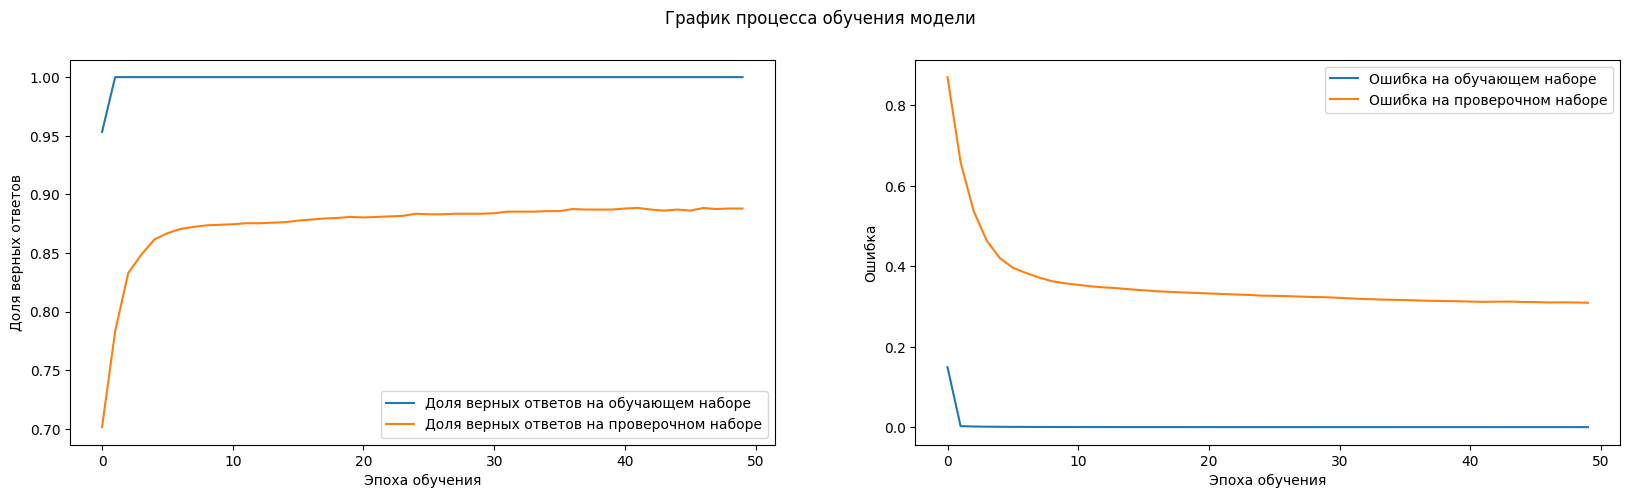

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


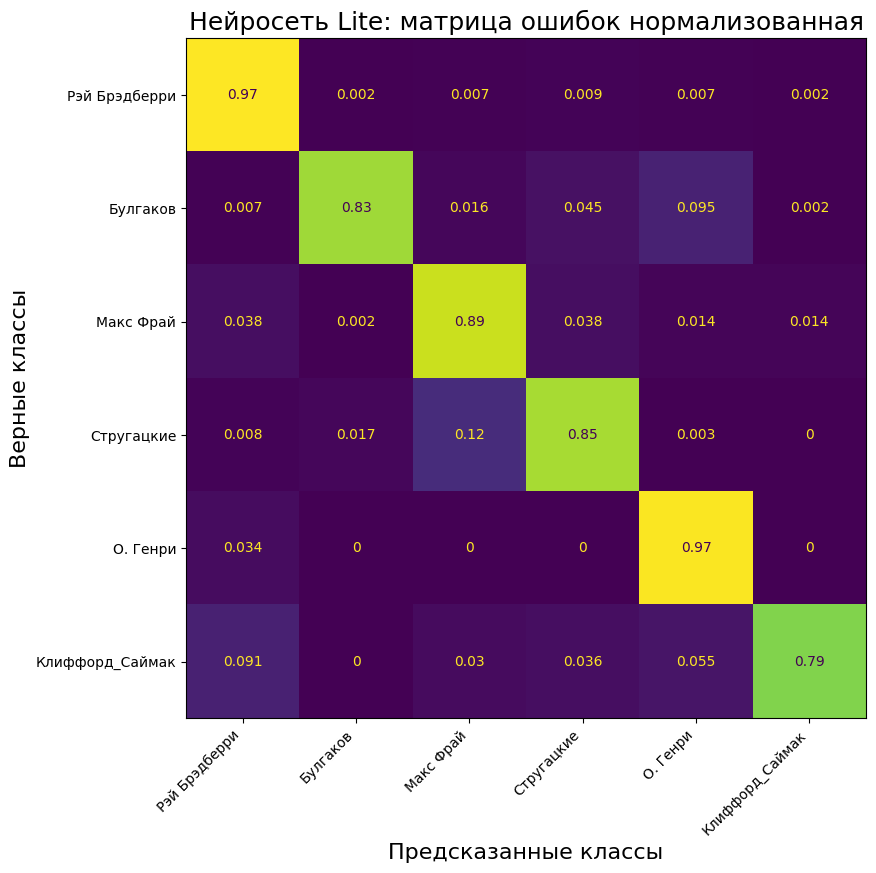

----------------------------------------------------------------------------------------------------
Нейросеть: Lite
Класс: Рэй Брэдберри         97% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)
Класс: Булгаков              83% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Макс Фрай             89% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: Стругацкие            85% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: О. Генри              97% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Клиффорд_Саймак       79% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)

Средняя точность распознавания:  88%
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9208 - loss: 0.2286


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 256)            │     2,560,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,595,462 (9.90 MB)

 Trainable params: 2,594,694 (9.90 MB)

 Non-trainable params: 768 (3.00 KB)

Start training...
Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.7619 - loss: 0.6948 - val_accuracy: 0.7019 - val_loss: 0.9108
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0173 - val_accuracy: 0.7768 - val_loss: 0.7078
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0075 - val_accuracy: 0.8198 - val_loss: 0.5835
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 0.8489 - val_loss: 0.4962
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.8610 - val_loss: 0.4481
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.8749 - val_loss: 0.4110
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.8799 - val_loss: 0.3899
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy:

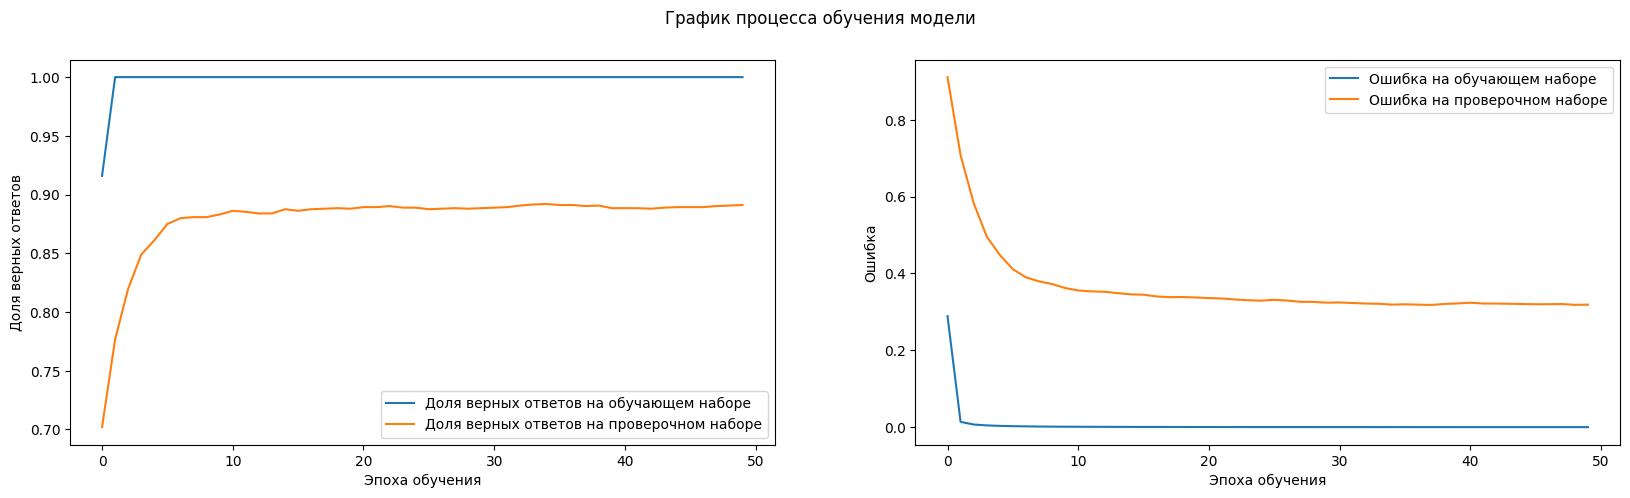

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


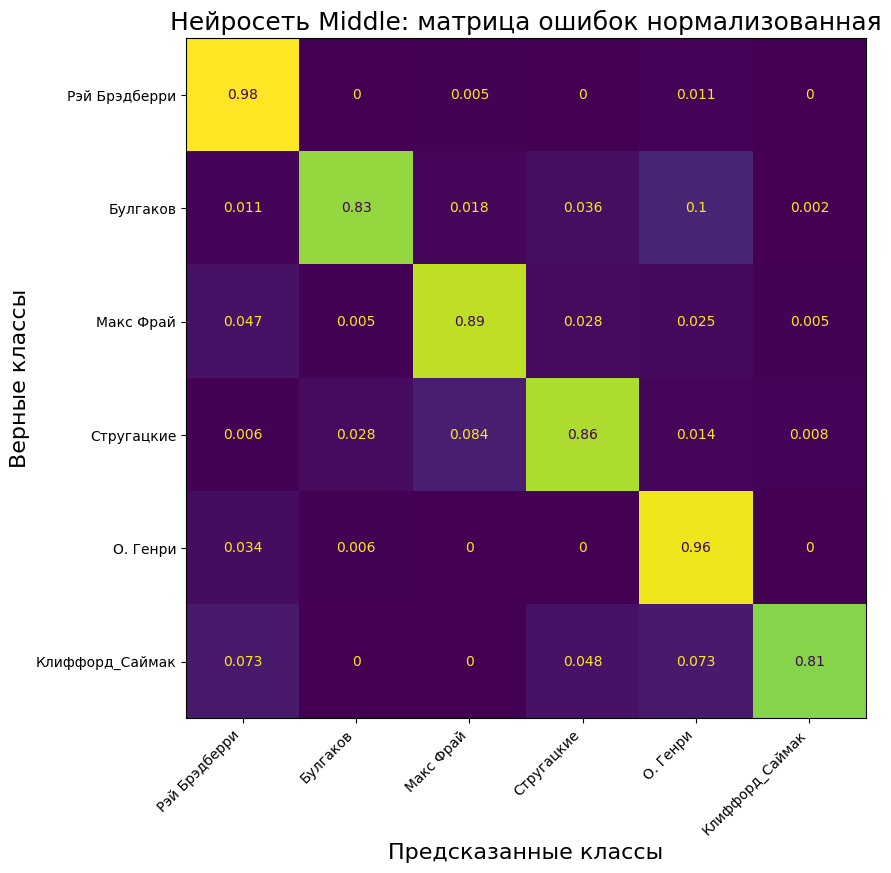

----------------------------------------------------------------------------------------------------
Нейросеть: Middle
Класс: Рэй Брэдберри         98% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)
Класс: Булгаков              83% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Макс Фрай             89% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: Стругацкие            86% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: О. Генри              96% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Клиффорд_Саймак       81% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)

Средняя точность распознавания:  89%
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9249 - loss: 0.2170


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 256)            │     2,560,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,603,590 (9.93 MB)

 Trainable params: 2,602,694 (9.93 MB)

 Non-trainable params: 896 (3.50 KB)

Start training...
Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.6731 - loss: 0.9937 - val_accuracy: 0.6992 - val_loss: 0.9537
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9974 - loss: 0.0821 - val_accuracy: 0.8001 - val_loss: 0.6522
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0330 - val_accuracy: 0.8512 - val_loss: 0.5122
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0195 - val_accuracy: 0.8691 - val_loss: 0.4307
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0131 - val_accuracy: 0.8794 - val_loss: 0.3758
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0099 - val_accuracy: 0.8893 - val_loss: 0.3399
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 0.8956 - val_loss: 0.3171
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy:

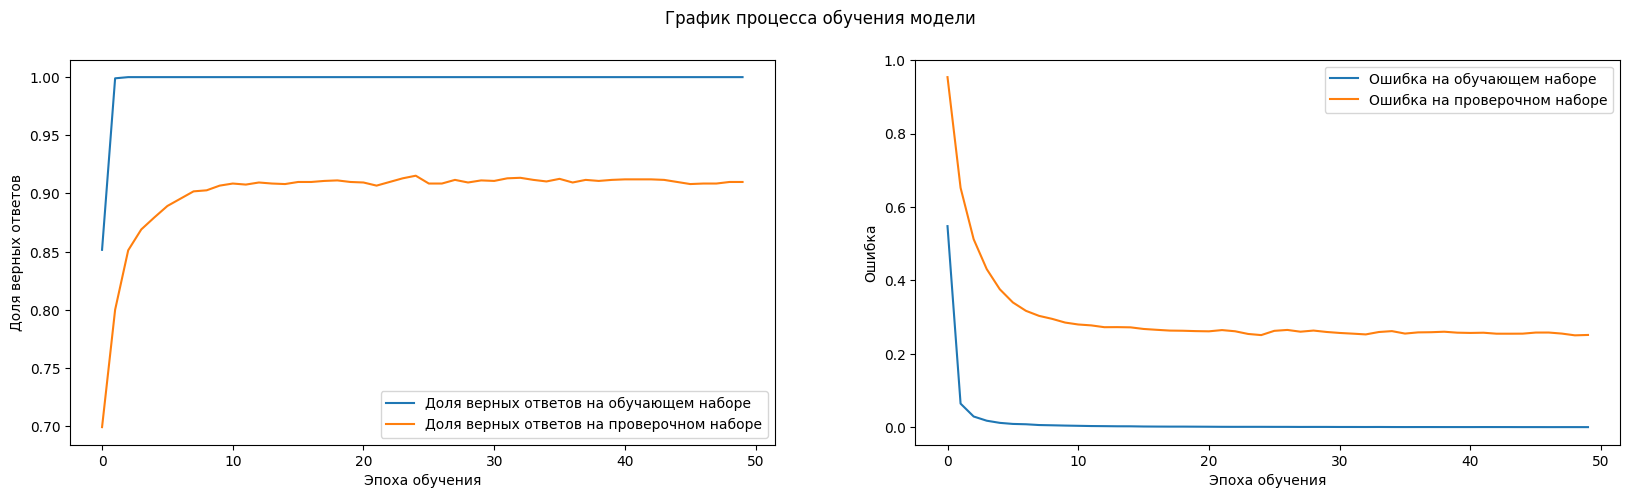

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


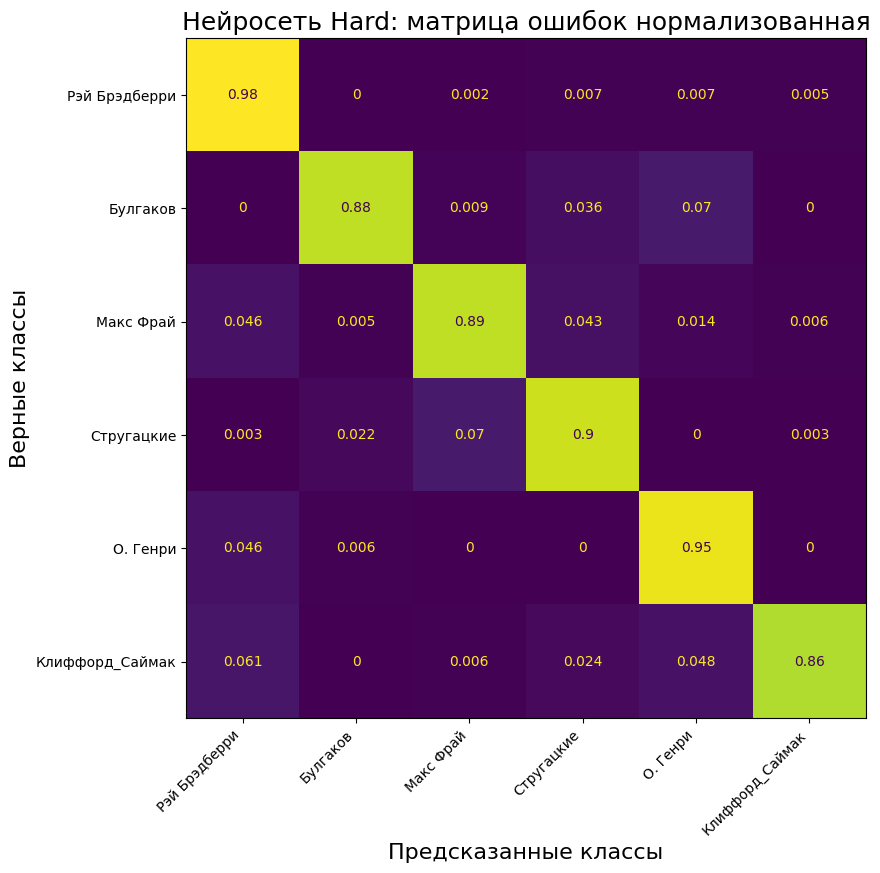

----------------------------------------------------------------------------------------------------
Нейросеть: Hard
Класс: Рэй Брэдберри         98% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)
Класс: Булгаков              88% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Макс Фрай             89% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: Стругацкие            90% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: О. Генри              95% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Клиффорд_Саймак       86% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)

Средняя точность распознавания:  91%
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9387 - loss: 0.1780


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 256)            │     3,072,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,074,822 (11.73 MB)

 Trainable params: 3,074,310 (11.73 MB)

 Non-trainable params: 512 (2.00 KB)

Start training...
Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.8472 - loss: 0.4317 - val_accuracy: 0.7313 - val_loss: 0.7890
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.7798 - val_loss: 0.6226
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.8284 - val_loss: 0.5084
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.2143e-04 - val_accuracy: 0.8542 - val_loss: 0.4329
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.5813e-04 - val_accuracy: 0.8794 - val_loss: 0.3810
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.4581e-04 - val_accuracy: 0.8914 - val_loss: 0.3485
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 4.8131e-04 - val_accuracy: 0.8998 - val_loss: 0.3272
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.6240

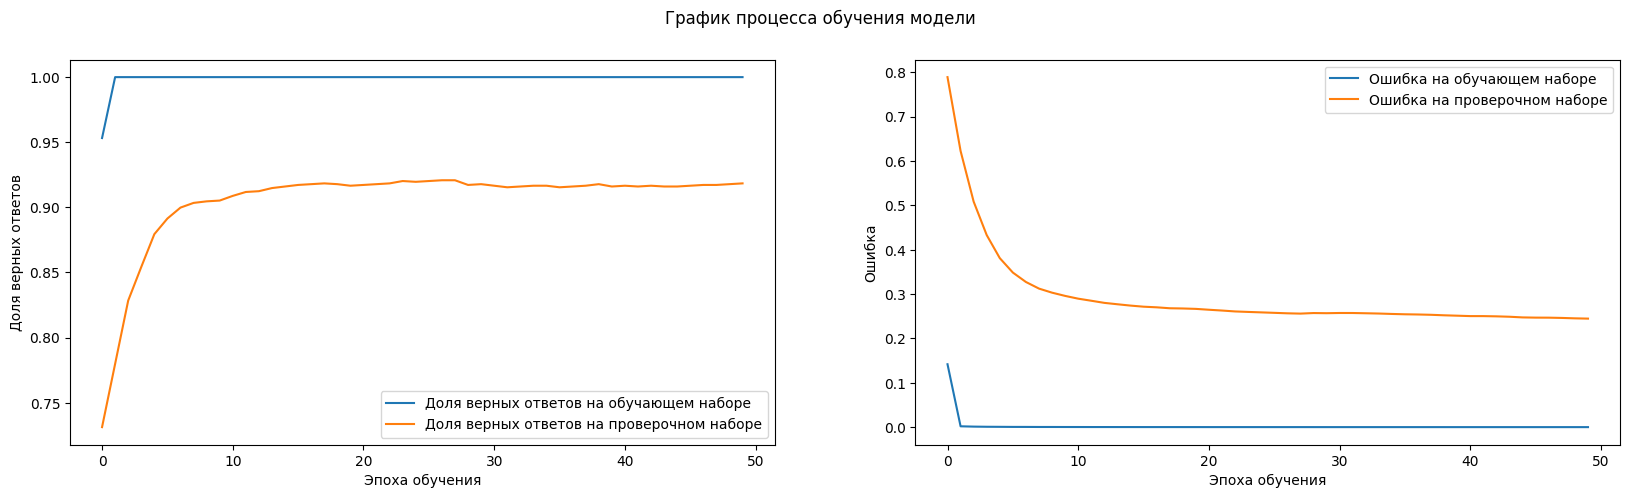

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


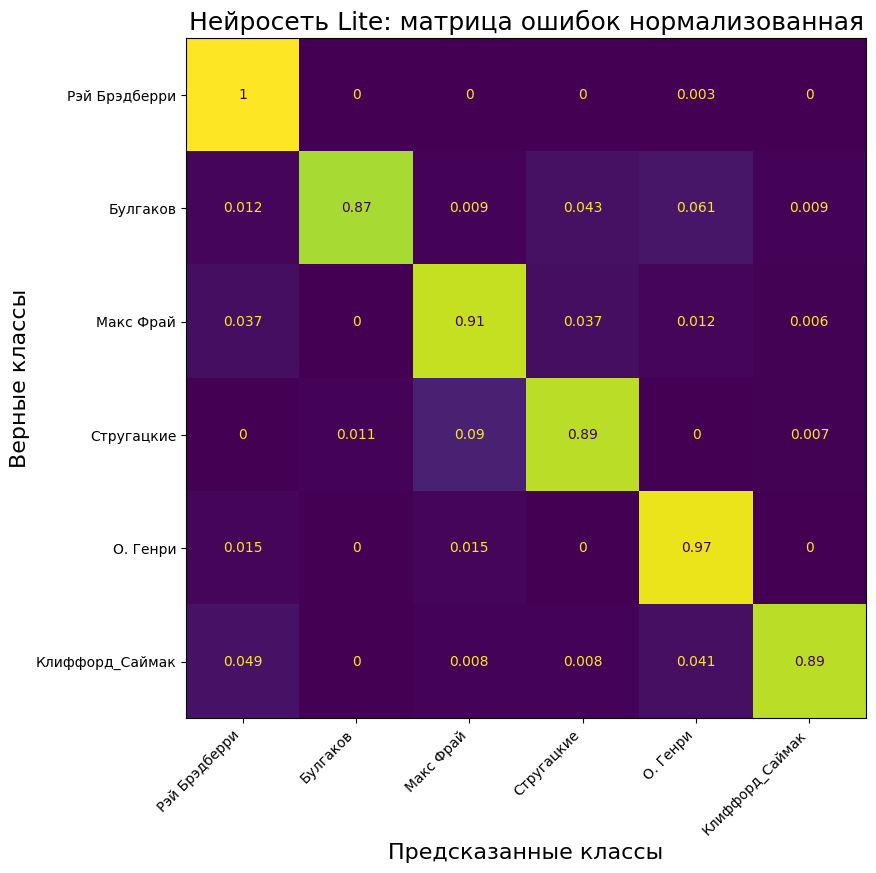

----------------------------------------------------------------------------------------------------
Нейросеть: Lite
Класс: Рэй Брэдберри        100% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)
Класс: Булгаков              87% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Макс Фрай             91% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: Стругацкие            89% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: О. Генри              97% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Клиффорд_Саймак       89% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)

Средняя точность распознавания:  92%
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9468 - loss: 0.1670


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 256)            │     3,072,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,107,462 (11.85 MB)

 Trainable params: 3,106,694 (11.85 MB)

 Non-trainable params: 768 (3.00 KB)

Start training...
Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.7652 - loss: 0.7155 - val_accuracy: 0.7067 - val_loss: 0.8566
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0188 - val_accuracy: 0.7774 - val_loss: 0.6653
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0086 - val_accuracy: 0.8308 - val_loss: 0.5388
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 0.8614 - val_loss: 0.4502
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.8926 - val_loss: 0.3915
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.9070 - val_loss: 0.3480
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9106 - val_loss: 0.3215
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accura

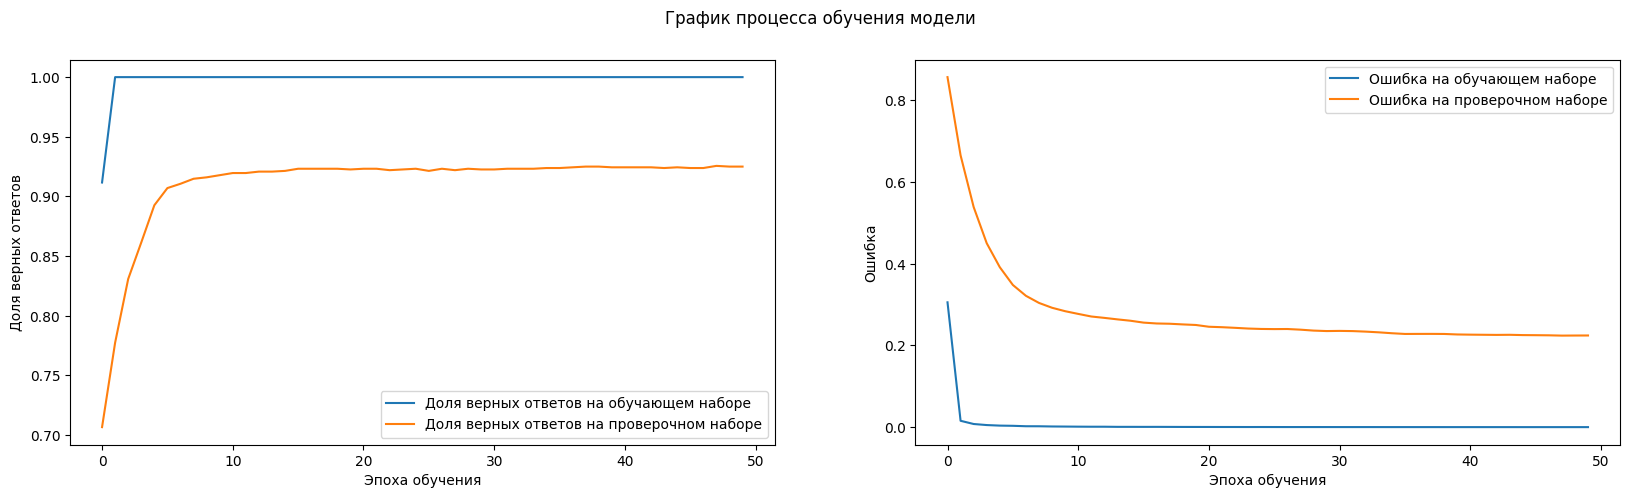

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


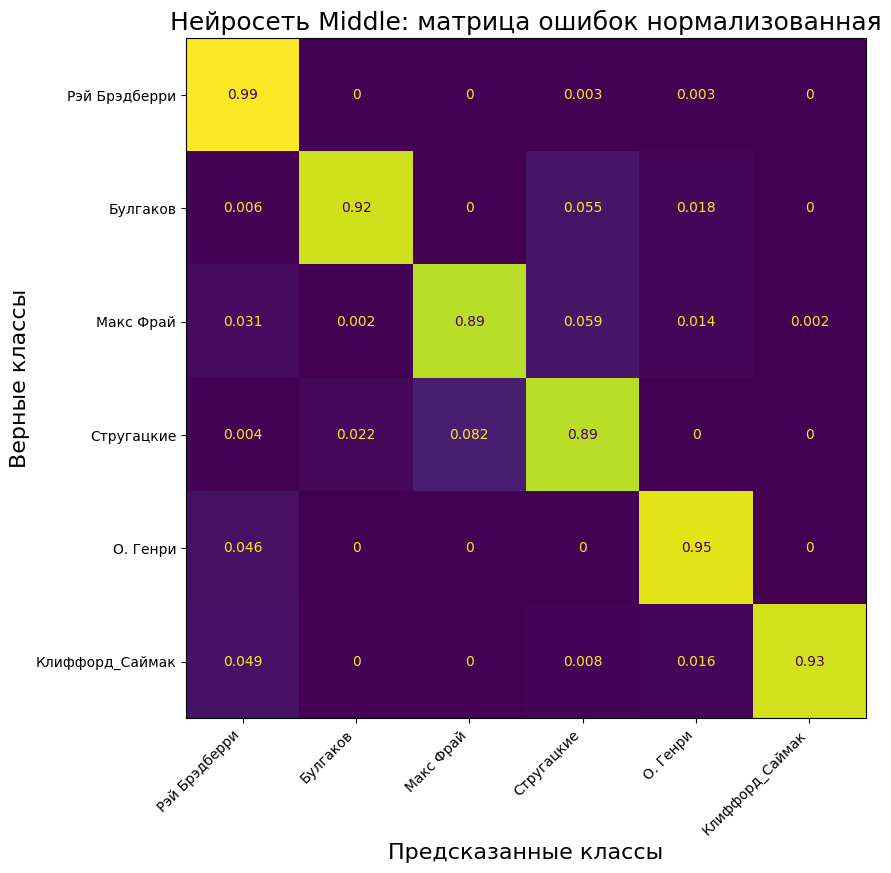

----------------------------------------------------------------------------------------------------
Нейросеть: Middle
Класс: Рэй Брэдберри         99% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)
Класс: Булгаков              92% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Макс Фрай             89% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: Стругацкие            89% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: О. Генри              95% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Клиффорд_Саймак       93% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)

Средняя точность распознавания:  93%
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9575 - loss: 0.1364


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                │ (None, 256)            │     3,072,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,115,590 (11.89 MB)

 Trainable params: 3,114,694 (11.88 MB)

 Non-trainable params: 896 (3.50 KB)

Start training...
Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.6728 - loss: 1.0003 - val_accuracy: 0.6893 - val_loss: 0.8924
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.1122 - val_accuracy: 0.7666 - val_loss: 0.7001
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0420 - val_accuracy: 0.8074 - val_loss: 0.5878
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9996 - loss: 0.0287 - val_accuracy: 0.8422 - val_loss: 0.5010
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9999 - loss: 0.0192 - val_accuracy: 0.8746 - val_loss: 0.4265
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0146 - val_accuracy: 0.8824 - val_loss: 0.3844
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0108 - val_accuracy: 0.8872 - val_loss: 0.3590
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0087 - val_accu

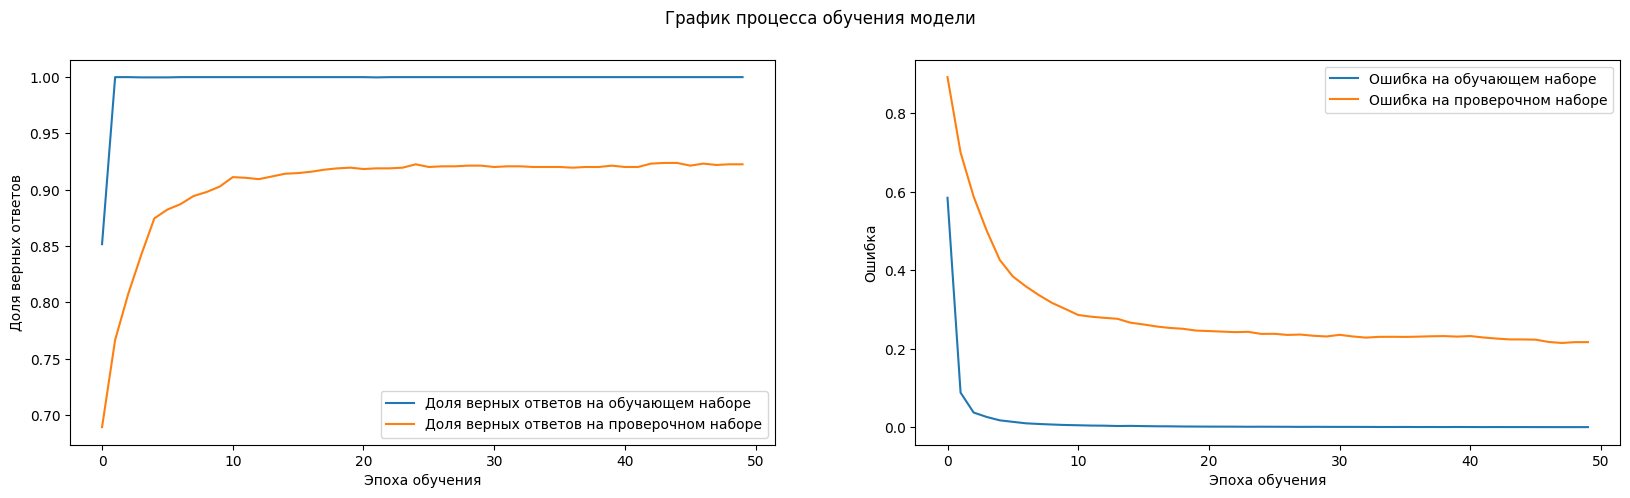

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


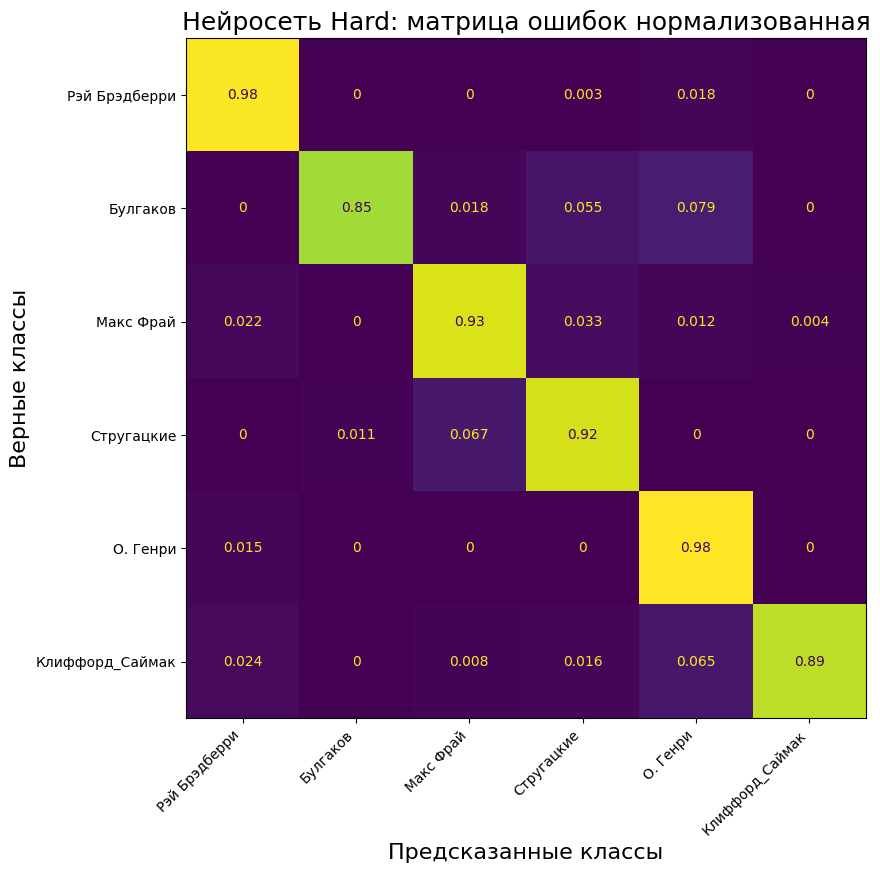

----------------------------------------------------------------------------------------------------
Нейросеть: Hard
Класс: Рэй Брэдберри         98% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)
Класс: Булгаков              85% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Макс Фрай             93% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: Стругацкие            92% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: О. Генри              98% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Клиффорд_Саймак       89% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)

Средняя точность распознавания:  92%
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9348 - loss: 0.1742


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 256)            │     3,840,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,842,822 (14.66 MB)

 Trainable params: 3,842,310 (14.66 MB)

 Non-trainable params: 512 (2.00 KB)

Start training...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.8454 - loss: 0.4485 - val_accuracy: 0.7410 - val_loss: 0.6953
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.7989 - val_loss: 0.5460
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.8517 - val_loss: 0.4439
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.8855 - val_loss: 0.3805
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 6.9729e-04 - val_accuracy: 0.9096 - val_loss: 0.3401
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 5.7758e-04 - val_accuracy: 0.9187 - val_loss: 0.3129
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 4.8458e-04 - val_accuracy: 0.9270 - val_loss: 0.2933
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 4.4567

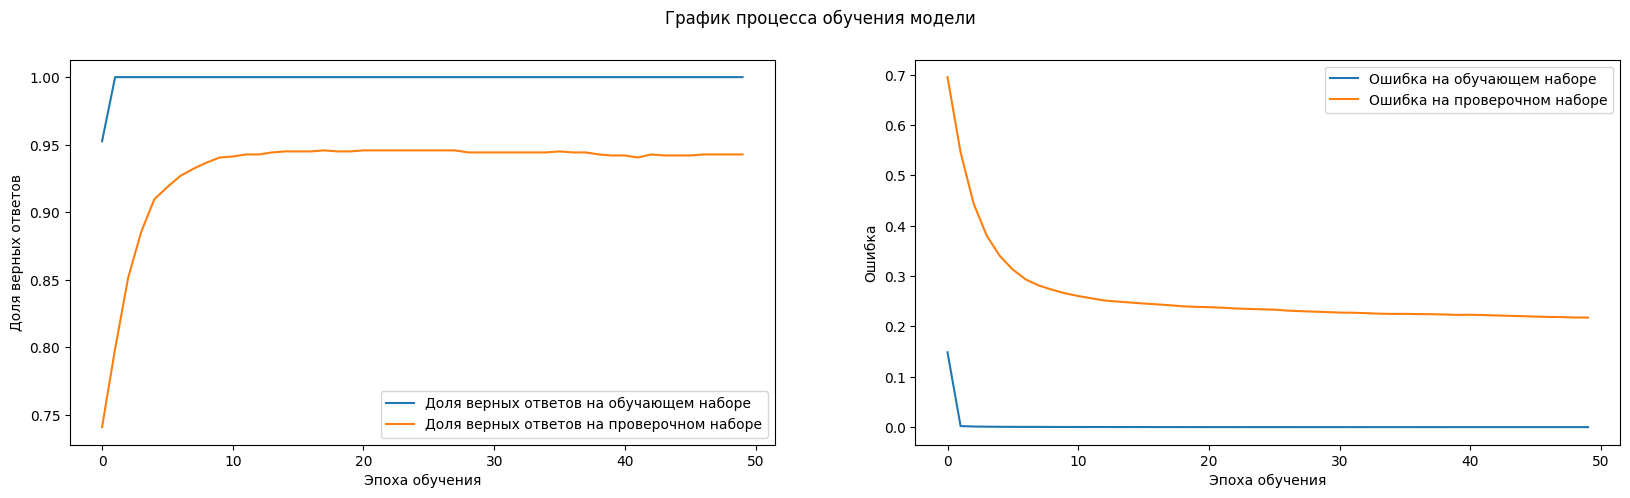

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


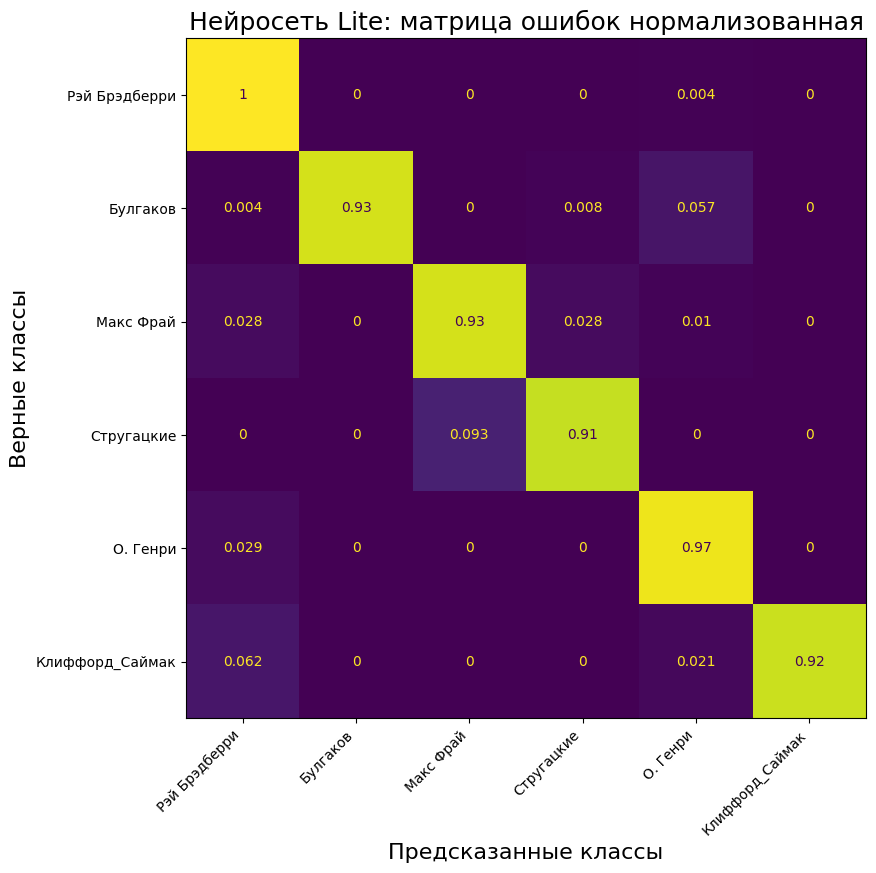

----------------------------------------------------------------------------------------------------
Нейросеть: Lite
Класс: Рэй Брэдберри        100% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)
Класс: Булгаков              93% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Макс Фрай             93% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: Стругацкие            91% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: О. Генри              97% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Клиффорд_Саймак       92% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)

Средняя точность распознавания:  94%
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9670 - loss: 0.1500


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_29 (Dense)                │ (None, 256)            │     3,840,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,875,462 (14.78 MB)

 Trainable params: 3,874,694 (14.78 MB)

 Non-trainable params: 768 (3.00 KB)

Start training...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.7935 - loss: 0.6271 - val_accuracy: 0.7048 - val_loss: 0.7961
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9999 - loss: 0.0198 - val_accuracy: 0.7884 - val_loss: 0.6074
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 0.8321 - val_loss: 0.5137
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0056 - val_accuracy: 0.8622 - val_loss: 0.4434
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.8742 - val_loss: 0.3965
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.8886 - val_loss: 0.3602
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.8991 - val_loss: 0.3361
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0020 - val_a

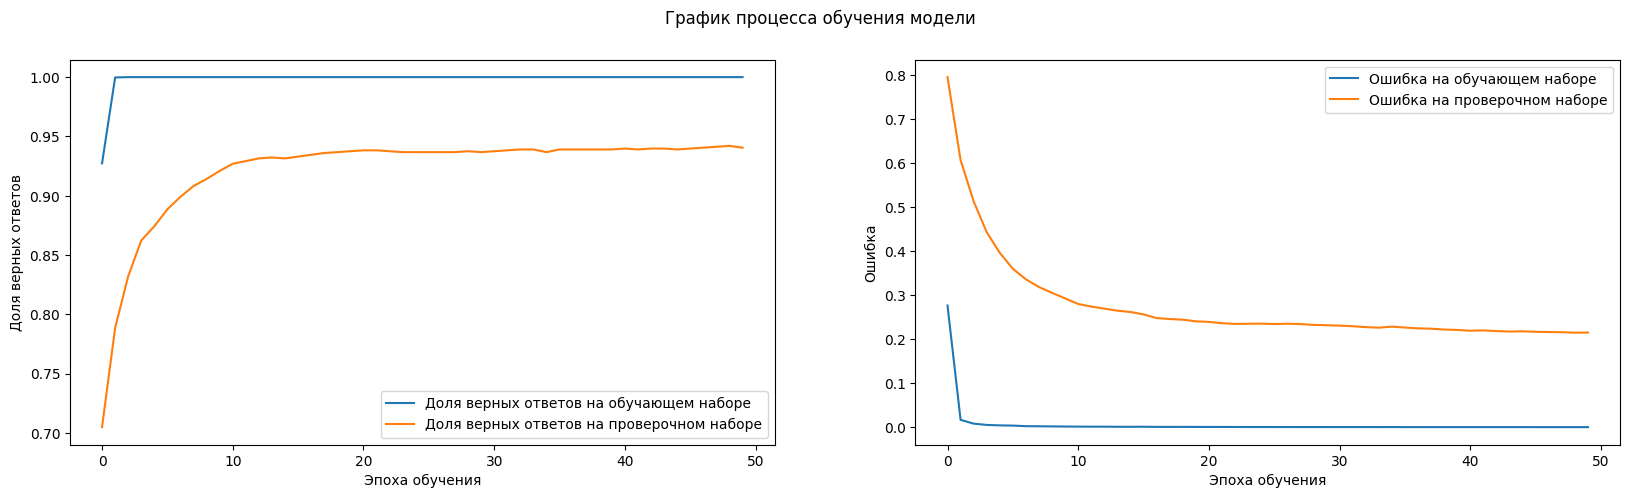

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


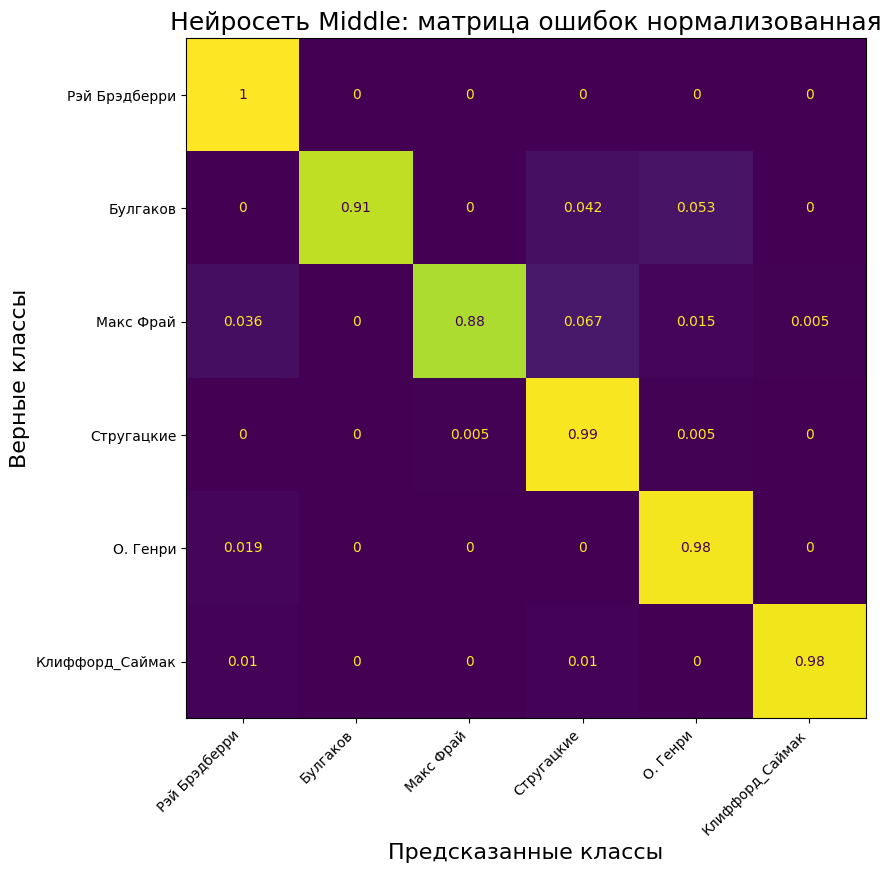

----------------------------------------------------------------------------------------------------
Нейросеть: Middle
Класс: Рэй Брэдберри        100% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)
Класс: Булгаков              90% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Макс Фрай             88% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: Стругацкие            99% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: О. Генри              98% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Клиффорд_Саймак       98% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)

Средняя точность распознавания:  96%
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9566 - loss: 0.1642


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                │ (None, 256)            │     3,840,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,883,590 (14.81 MB)

 Trainable params: 3,882,694 (14.81 MB)

 Non-trainable params: 896 (3.50 KB)

Start training...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.6464 - loss: 1.0616 - val_accuracy: 0.7289 - val_loss: 0.8781
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9982 - loss: 0.1331 - val_accuracy: 0.8170 - val_loss: 0.6284
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0554 - val_accuracy: 0.8712 - val_loss: 0.4908
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0345 - val_accuracy: 0.9029 - val_loss: 0.4006
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0257 - val_accuracy: 0.9202 - val_loss: 0.3401
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0188 - val_accuracy: 0.9315 - val_loss: 0.2969
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0154 - val_accuracy: 0.9413 - val_loss: 0.2652
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0123 - val_a

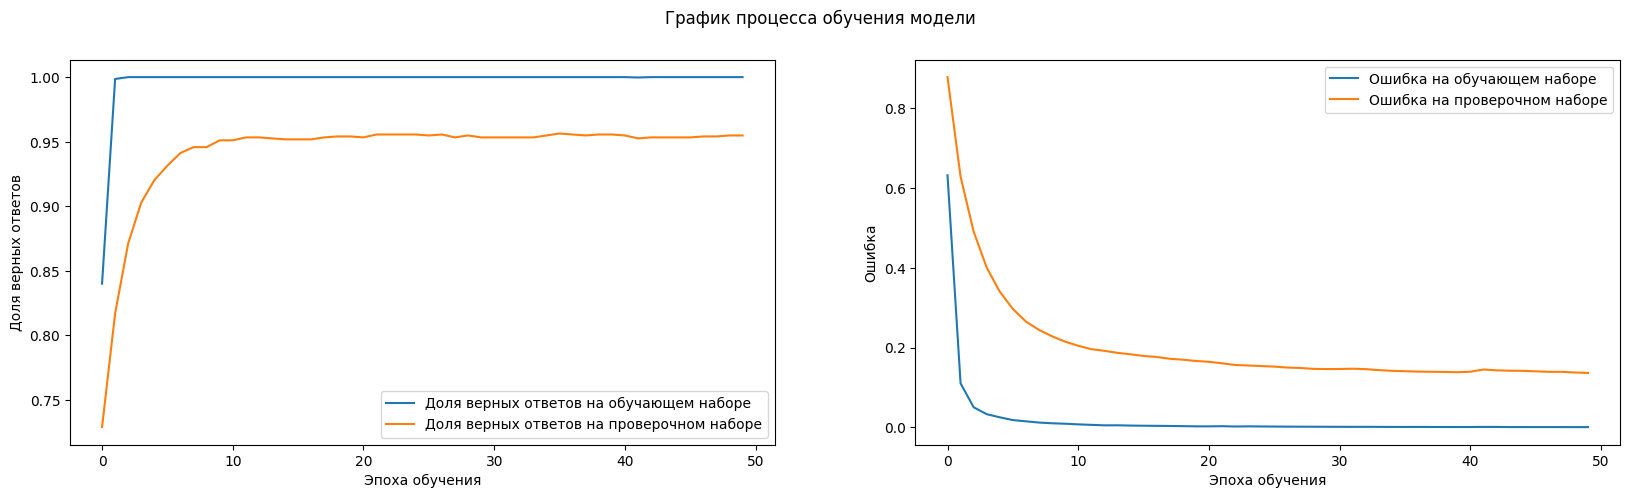

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


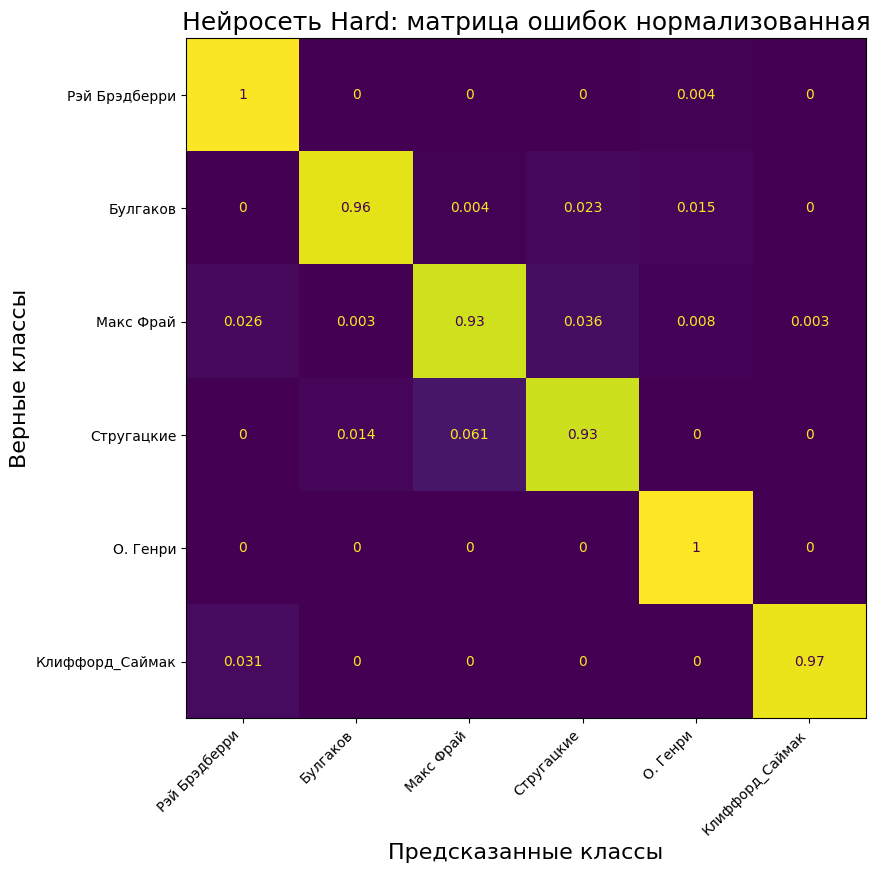

----------------------------------------------------------------------------------------------------
Нейросеть: Hard
Класс: Рэй Брэдберри        100% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)
Класс: Булгаков              96% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Макс Фрай             93% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: Стругацкие            92% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: О. Генри             100% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Клиффорд_Саймак       97% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)

Средняя точность распознавания:  96%
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9735 - loss: 0.0841
Время обработки: 349.21 с


In [18]:
with timex():
    results = {
        "Размер словаря": [],
        "Ширина окна": [],
        "Шаг окна": [],
        "Название модели": [],
        "Количество слоев": [],
        "Нейроны в 1 слое": [],
        "Точность (val_accuracy)": [],
    }
    for vocab_size, win_size, win_hope in PARAMS:
        results["Размер словаря"].extend([vocab_size] * 3)
        results["Ширина окна"].extend([win_size] * 3)
        results["Шаг окна"].extend([win_hope] * 3)

        # Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
        tokenizer = Tokenizer(
            num_words=vocab_size,
            filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
            lower=True,
            split=" ",
            oov_token="неизвестное_слово",
            char_level=False,
        )

        # Использованы параметры:
        # num_words   - объем словаря
        # filters     - убираемые из текста ненужные символы
        # lower       - приведение слов к нижнему регистру
        # split       - разделитель слов
        # char_level  - указание разделять по словам, а не по единичным символам
        # oov_token   - токен для слов, которые не вошли в словарь

        # Построение частотного словаря по обучающим текстам
        tokenizer.fit_on_texts(text_train)
        seq_train = tokenizer.texts_to_sequences(text_train)
        seq_test = tokenizer.texts_to_sequences(text_test)
        # Формирование обучающей выборки
        x_train, y_train = vectorize_sequence(seq_train, win_size, win_hope)
        # Формирование тестовой выборки
        x_test, y_test = vectorize_sequence(seq_test, win_size, win_hope)
        x_train = tokenizer.sequences_to_matrix(x_train.tolist()).astype("float16")
        x_test = tokenizer.sequences_to_matrix(x_test.tolist()).astype("float16")
        create_and_train_models(vocab_size, results, x_train, y_train, x_test, y_test)